In [5]:
from  model.seriesNet_torch import *
import model.seriesNet_torch as SN_torch
import SeriesNetTrainTestManager
from model.seriesNet_torch import seriesNet 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
import random
#import glob
from data_set.action_500FN import action, load_dataset
import matplotlib.pyplot as plt
#%matplotlib notebook
import data_set.fn_500_dataset as fn_500_dataset
from data_set.fn_500_dataset import ActionDataset
from torch.utils.data import DataLoader
import importlib
import SeriesNetTrainTestManager as SNTTM
import CausalTrainTest
import itertools
from CausalTrainTest import TrainManager

In [107]:
!python train.py --company=HOLX_data --num_epochs=7 --pts_2_pred=20 --save --figname=blk8_20pt_HOLX_32f_schTr

False
Training seriesNet for 7 epochs
Figure(640x480)
Figure(640x480)


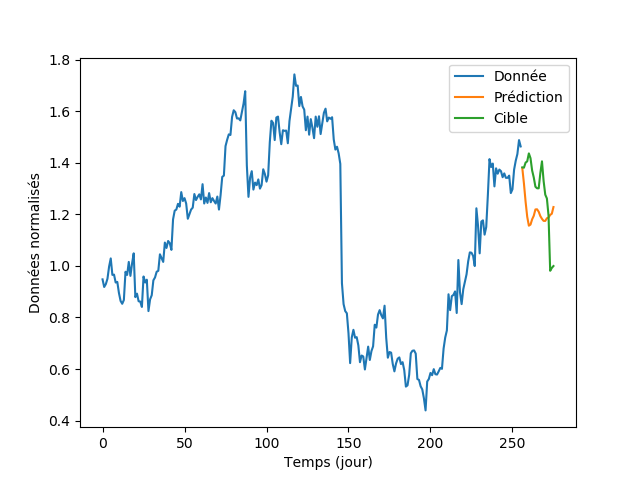

In [108]:
from IPython.display import Image
Image(filename='blk8_20pt_HOLX_32f_schTr_pred.png')  

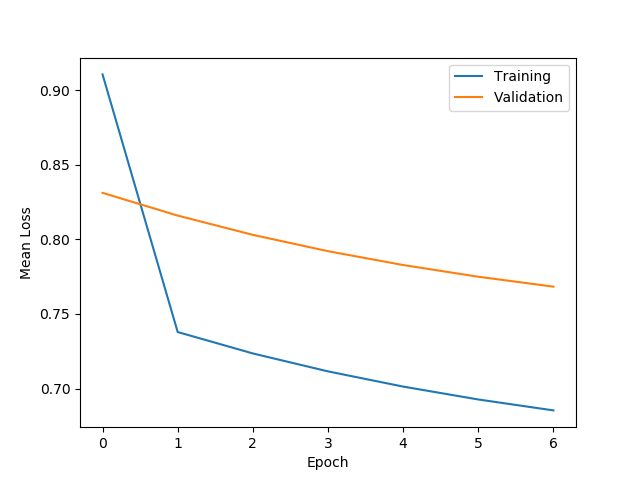

In [76]:
Image(filename='blk8_20pt_AAPL_32f_schTr_metric.png')

In [131]:
!python train_schBatch.py --nb_causal_blk=8 --company=HOLX_data --num_epochs=7 --pts_2_pred=20 --save --figname=nope

196
787
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7
Figure(640x480)
196
787
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7
Figure(640x480)
[False False False False False False False False False False False False
 False False False False False False False False]
Figure(640x480)


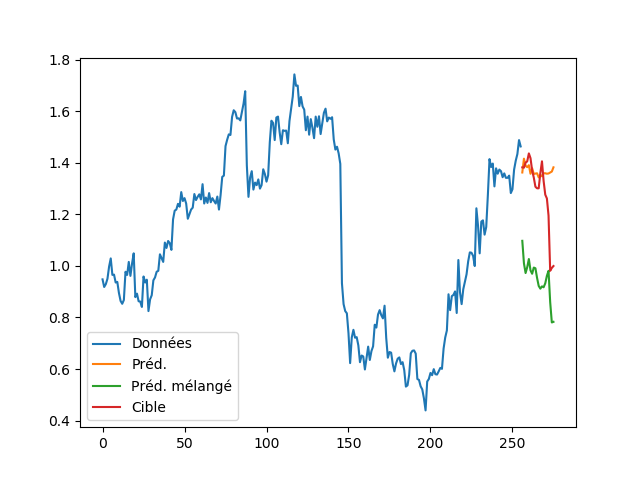

In [132]:
Image(filename='nope.png')

In [3]:
!python hyperparam_search.py --company=AAPL_data --nb_causal_blk 5  --nb_filter 16  --nb_drop_blk 3  --lr 0.001

Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 3, opti : sgd
241
966
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 3, opti : Adam
241
966
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7
Combinaison gagnante :  (5, 0.001, 16, 3, 'sgd')


In [112]:
!python train_schBatch.py --company=AAPL_data --nb_causal_blk 5  --nb_filter 16  --nb_drop_blk 3  --lr 0.001

train_window :  torch.Size([974, 1, 32])
target_train :  torch.Size([974, 1, 1])
eval_train :  torch.Size([243, 1, 32])
eval_target :  torch.Size([243, 1, 1])
test_input :  torch.Size([1, 1, 32])
test_target :  torch.Size([1, 1, 10])
243
974
Training seriesNet for 7 epochs
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7
Figure(640x480)
train_window :  torch.Size([974, 1, 32])
target_train :  torch.Size([974, 1, 1])
eval_train :  torch.Size([243, 1, 32])
eval_target :  torch.Size([243, 1, 1])
test_input :  torch.Size([1, 1, 32])
test_target :  torch.Size([1, 1, 10])
243
974
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7
Figure(640x480)
Figure(640x480)


In [22]:

nb_causal_blk = [5, 6, 7, 8, 9]
learning_rate = np.random.choice(np.arange(1,11),3,replace=False)/10000
nb_filter = [16, 24, 32]
nb_drop_blk = [2, 3, 4]
optimizer=['sgd', 'Adam']
batch_size = 15
num_epochs = 7
#val_percent = args.validation
channel_2_use = 'close'
pts_2_pred = 15
company = 'AAPL_data'
validation = 20
shuffle = False
result={}

for causal_b, lr, filter, drop_blk,opti in itertools.product(nb_causal_blk, learning_rate, nb_filter, nb_drop_blk, optimizer ):
    converge = False
    print("Training for causal_b : {}, lr : {}, filter : {}, drop_blk : {}, opti : {}".format(causal_b, lr, filter, drop_blk,opti))
    
    while not converge:
        model = seriesNet(1, nb_causal_block=causal_b, gate_nb_filter=filter, nb_block_dropped=drop_blk)
        model.float()
        N = model.get_pts_for_Pred()
        dataset_train, dataset_eval, test_input, test_target = fn_500_dataset.create_sliding_dataset(N,
                                                                            pts_2_pred=pts_2_pred,
                                                                            proportion=validation,
                                                                            action_name=company,
                                                                            axis=channel_2_use,
                                                                            normalise=True)

        train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle, drop_last=False)
        valid_loader = DataLoader(dataset_eval, batch_size=batch_size, shuffle=shuffle, drop_last=False)

        manager = TrainManager(model,
                               train_loader,
                               valid_loader,
                               lr=lr,
                               loss_fn='MeanSquared',
                               optimizer_type=opti,
                               pts_2pred=pts_2_pred)

        manager.train(num_epochs,display=False)
        pred = manager.predict(test_input, test_target)
        if len(np.unique(pred)) != 1:
            converge=True
            loss= np.mean((test_target.view(-1).detach().numpy() - pred)**2)
            result[(causal_b, lr, filter, drop_blk,opti)]= loss
        else:
            print('problemo')

print("Combinaison gagnante : ", min(result, key=result.get) )

Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 2, opti : sgd
problemo
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 2, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 3, opti : sgd
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 3, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 4, opti : sgd
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 4, opti : Adam
problemo
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 2, opti : sgd
problemo
problemo
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 2, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 3, opti : sgd
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 3, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 4, opti : sgd
problemo
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 4, opti : Adam
Training for causal_b : 5

Training for causal_b : 8, lr : 0.0008, filter : 32, drop_blk : 4, opti : sgd
problemo
Training for causal_b : 8, lr : 0.0008, filter : 32, drop_blk : 4, opti : Adam
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 2, opti : sgd
problemo
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 2, opti : Adam
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 3, opti : sgd
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 3, opti : Adam
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 4, opti : sgd
problemo
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 4, opti : Adam
problemo
problemo
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 2, opti : sgd
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 2, opti : Adam
problemo
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 3, opti : sgd
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 3, opti : Adam
prob

In [109]:
result

{(5, 0.001, 16, 2, 'sgd'): 0.12760962202122908,
 (5, 0.001, 16, 2, 'Adam'): 0.06672052914134857,
 (5, 0.001, 16, 3, 'sgd'): 2.3808968423632026,
 (5, 0.001, 16, 3, 'Adam'): 1.991125393071345,
 (5, 0.001, 16, 4, 'sgd'): 2.4054364778498893,
 (5, 0.001, 16, 4, 'Adam'): 3.8612958466520704,
 (5, 0.001, 24, 2, 'sgd'): 0.7655813446758628,
 (5, 0.001, 24, 2, 'Adam'): 2.133296752992614,
 (5, 0.001, 24, 3, 'sgd'): 0.03236626399855614,
 (5, 0.001, 24, 3, 'Adam'): 0.15377187179410706,
 (5, 0.001, 24, 4, 'sgd'): 2.409932104217057,
 (5, 0.001, 24, 4, 'Adam'): 1.0510785343613656,
 (5, 0.001, 32, 2, 'sgd'): 0.008905918263424913,
 (5, 0.001, 32, 2, 'Adam'): 1.7719805889823945,
 (5, 0.001, 32, 3, 'sgd'): 0.12374663271540763,
 (5, 0.001, 32, 3, 'Adam'): 0.07615954460020476,
 (5, 0.001, 32, 4, 'sgd'): 0.10751175805569062,
 (5, 0.001, 32, 4, 'Adam'): 0.46856557369940693,
 (5, 0.0008, 16, 2, 'sgd'): 4.810507176217073,
 (5, 0.0008, 16, 2, 'Adam'): 4.226568088830112,
 (5, 0.0008, 16, 3, 'sgd'): 0.2293187853407